In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

from ConnectMySQL import Connector

In [32]:
conn = Connector(
        server   = 'localhost',
        port     = 3306,
        database = 'sakila',
        username = 'root',
        password = "nguyin"
)
conn.connect()

Connected to MySQL


In [33]:
customer = conn.GetTableData('customer')
film = conn.GetTableData('film')
inventory = conn.GetTableData('inventory')
rental = conn.GetTableData('rental')

e:\Project\ML-in-Business-Analytics\SakilaMachineLearning\ConnectMySQL.py:34: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [34]:
# Merge the necessary tables to get the required information
customer_rental = pd.merge(customer, rental, on='customer_id', suffixes=('_customer', '_rental'))
customer_rental_inventory = pd.merge(customer_rental, inventory, on='inventory_id', suffixes=('_rental', '_inventory'))
customer_rental_inventory_film = pd.merge(customer_rental_inventory, film, on='film_id', suffixes=('_inventory', '_film'))

# Calculate total payment
total_payment = customer_rental_inventory_film.groupby('customer_id')['rental_rate'].sum().reset_index()
total_payment.columns = ['customer_id', 'TotalPayment']

# Calculate rental frequency
rental_frequency = customer_rental_inventory_film.groupby('customer_id')['rental_id'].count().reset_index()
rental_frequency.columns = ['customer_id', 'RentalFrequency']

# Calculate average film length
average_film_length = customer_rental_inventory_film.groupby('customer_id')['length'].mean().reset_index()
average_film_length.columns = ['customer_id', 'AverageFilmLength']

# Calculate favorite rating
favorite_rating = customer_rental_inventory_film.groupby(['customer_id', 'rating']).size().reset_index(name='count')
favorite_rating = favorite_rating.loc[favorite_rating.groupby('customer_id')['count'].idxmax()]
favorite_rating = favorite_rating[['customer_id', 'rating']]
favorite_rating.columns = ['customer_id', 'FavoriteRating']

# Merge all the calculated data
df = pd.merge(customer[['customer_id', 'first_name', 'last_name']], total_payment, left_on = "customer_id", right_on = "customer_id")
df = pd.merge(df, rental_frequency, on='customer_id')
df = pd.merge(df, favorite_rating, on='customer_id')
df = pd.merge(df, average_film_length, on='customer_id')

# Rename columns
df.columns = ['CustomerId', 'FirstName', 'LastName', 'TotalPayment', 'RentalFrequency', 'FavoriteRating', 'AverageFilmLength']

print(df)

     CustomerId  FirstName   LastName  TotalPayment  RentalFrequency  \
0             1       MARY      SMITH         93.68               32   
1             2   PATRICIA    JOHNSON         82.73               27   
2             3      LINDA   WILLIAMS         85.74               26   
3             4    BARBARA      JONES         63.78               22   
4             5  ELIZABETH      BROWN         99.62               38   
..          ...        ...        ...           ...              ...   
594         595   TERRENCE  GUNDERSON         85.70               30   
595         596    ENRIQUE   FORSYTHE         77.72               28   
596         597    FREDDIE     DUGGAN         78.75               25   
597         598       WADE   DELVALLE         59.78               22   
598         599     AUSTIN    CINTRON         60.81               19   

    FavoriteRating  AverageFilmLength  
0            NC-17         122.375000  
1            PG-13         113.740741  
2              

In [35]:
# Create a mapping dictionary for favorite ratings
rating_mapping = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4,
    'NC-17': 5
}

# Map the favorite ratings to numbers
df['FavoriteRatingNumber'] = df['FavoriteRating'].map(rating_mapping)

# Create separate dataframes for each rating
df_g = df[df['FavoriteRatingNumber'] == 1]
df_pg = df[df['FavoriteRatingNumber'] == 2]
df_pg13 = df[df['FavoriteRatingNumber'] == 3]
df_r = df[df['FavoriteRatingNumber'] == 4]
df_nc17 = df[df['FavoriteRatingNumber'] == 5]

print(df_g)
print(df_pg)
print(df_pg13)
print(df_r)
print(df_nc17)

     CustomerId FirstName   LastName  TotalPayment  RentalFrequency  \
3             4   BARBARA      JONES         63.78               22   
8             9  MARGARET      MOORE         68.77               23   
9            10   DOROTHY     TAYLOR         64.75               25   
11           12     NANCY     THOMAS         67.72               28   
16           17     DONNA   THOMPSON         68.79               21   
..          ...       ...        ...           ...              ...   
577         578   WILLARD    LUMPKIN         69.78               22   
579         580      ROSS       GREY         68.73               27   
583         584  SALVADOR       TEEL         93.70               30   
592         593      RENE  MCALISTER         71.74               26   
597         598      WADE   DELVALLE         59.78               22   

    FavoriteRating  AverageFilmLength  FavoriteRatingNumber  
3                G         117.272727                     1  
8                G     

In [36]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
cluster_columns = ['TotalPayment', 'RentalFrequency', 'FavoriteRatingNumber', 'AverageFilmLength']
X = scaler.fit_transform(df[cluster_columns])

In [37]:
# Phương pháp Elbow và Silhouette để xác định số cụm tối ưu
def find_optimal_clusters(X, max_k=10):
    inertia = []
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)

    # Vẽ biểu đồ Elbow
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    # Vẽ biểu đồ Silhouette
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.show()

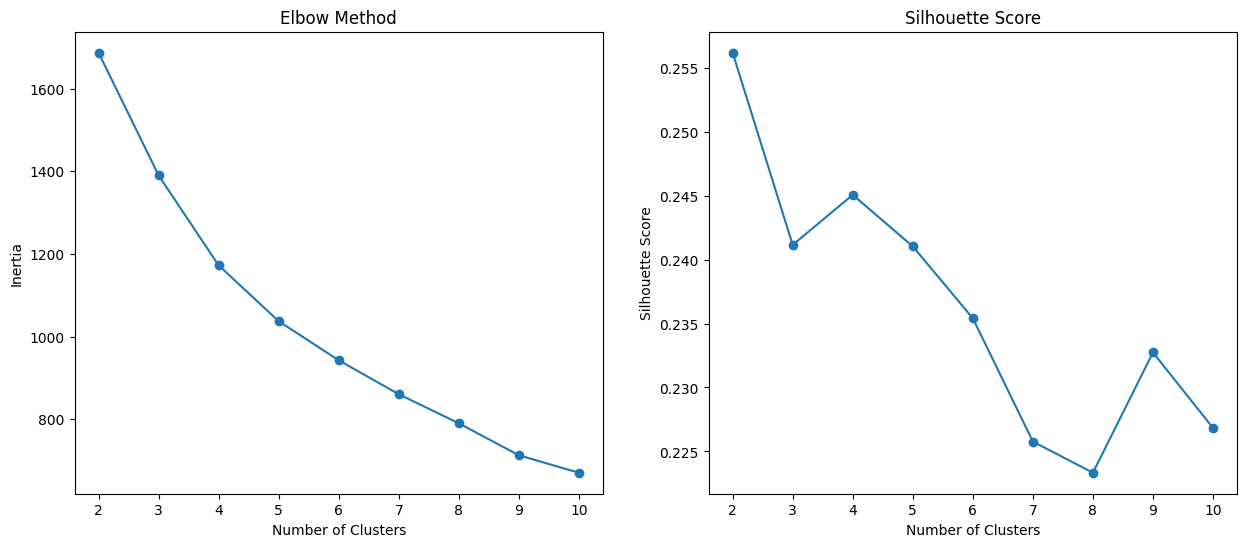

In [38]:
# Tìm số cụm tối ưu
find_optimal_clusters(X)

In [39]:
# Chọn số cụm
cluster = 3
kmeans = KMeans(n_clusters=cluster, init='k-means++', max_iter=500, random_state=42)
y_kmeans = kmeans.fit_predict(X)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Chuyển centroids về giá trị gốc
df['cluster'] = y_kmeans

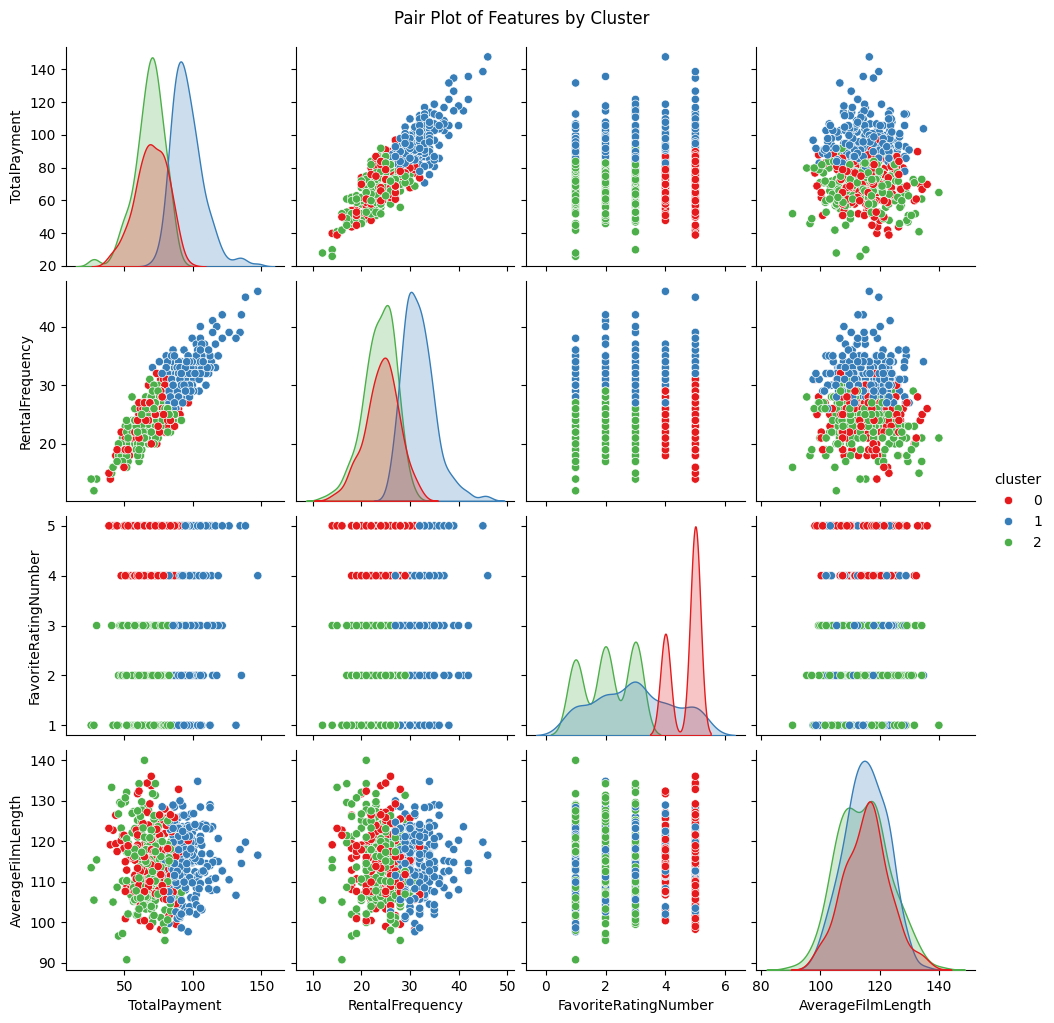

In [40]:
# --- Biểu đồ 1: Pair Plot ---
def plot_pair_plot(df, columns, hue):
    sns.pairplot(df, vars=columns, hue=hue, palette='Set1')
    plt.suptitle('Pair Plot of Features by Cluster', y=1.02)
    plt.show()


plot_pair_plot(df, cluster_columns, 'cluster')

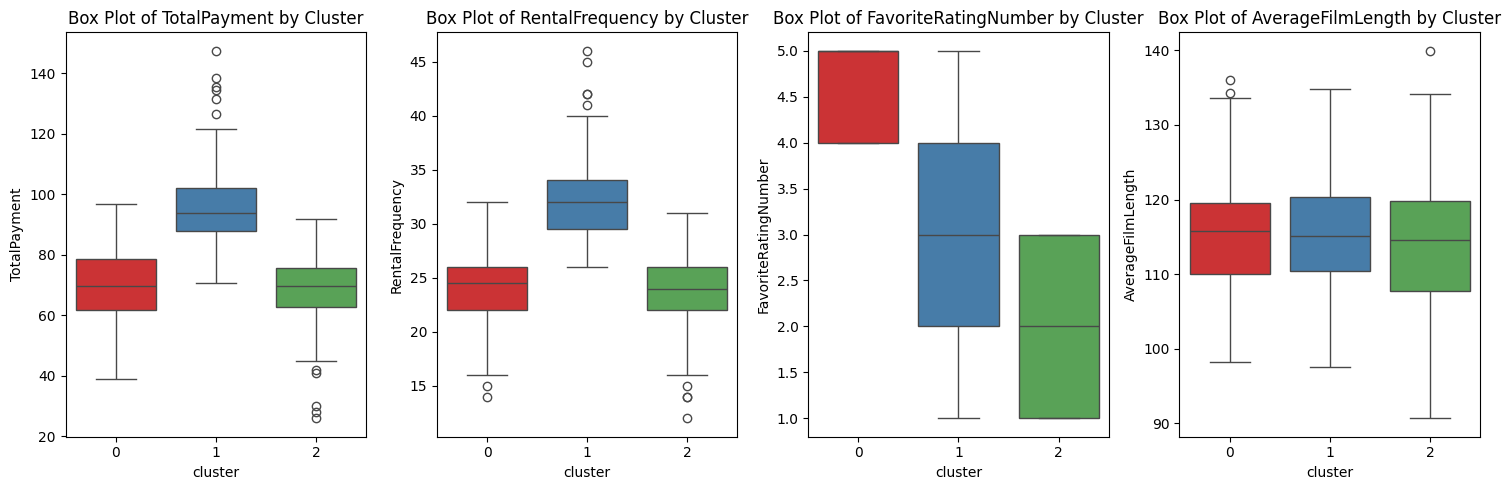

In [41]:
# --- Biểu đồ 2: Box Plot ---
def plot_box_plots(df, columns, hue):
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(x='cluster', y=col, data=df, hue='cluster', palette='Set1', legend=False)
        plt.title(f'Box Plot of {col} by Cluster')
    plt.tight_layout()
    plt.show()

plot_box_plots(df, cluster_columns, 'cluster')

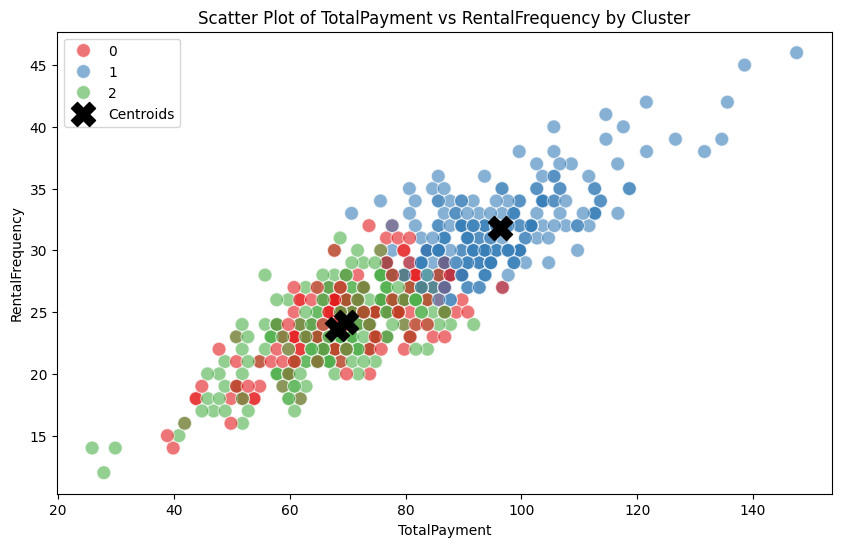

In [42]:
# --- Biểu đồ 3: Scatter Plot với Centroids ---
def plot_scatter_with_centroids(df, x_col, y_col, hue, centroids, colors):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, palette=colors, s=100, alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', label='Centroids')
    plt.title(f'Scatter Plot of {x_col} vs {y_col} by Cluster')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.show()
    
# Chọn hai đặc trưng để vẽ scatter plot
colors = sns.color_palette('Set1', n_colors=cluster)
plot_scatter_with_centroids(df, 'TotalPayment', 'RentalFrequency', 'cluster', centroids[:, [0, 1]], colors)

In [43]:
# --- Biểu đồ 4: 3D Scatter Plot ---
def visualize3DKmeans(df, columns, hover_data, cluster):
    fig = px.scatter_3d(
        df,
        x=columns[0],
        y=columns[1],
        z=columns[3],
        color='cluster',
        hover_data=hover_data,
        category_orders={"cluster": range(0, cluster)},
        labels={
            columns[0]: "Total Payment",
            columns[1]: "Rental Frequency",
            columns[3]: "Average Film Length"
        },
        title="3D Scatter Plot of Customer Clusters"
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
    fig.show()

# Dữ liệu để hiển thị khi hover
hover_data = ['CustomerId', 'FirstName', 'LastName']
visualize3DKmeans(df, cluster_columns, hover_data, cluster)

In [44]:
# Hàm lấy dữ liệu theo cụm
def get_customer_by_clusters(df, k):
    if k not in df["cluster"].unique():
        print(f"Cluster {k} không tồn tại trong dữ liệu.")
        return None
    cluster_data = df[df["cluster"] == k]
    print(f"\nCluster {k}: {len(cluster_data)} Customers\n")
    print(cluster_data[['CustomerId', 'TotalPayment', 'RentalFrequency', 'FavoriteRating', 'cluster']].head(10))
    print("-" * 50)
    return cluster_data

# Xem dữ liệu của một cụm cụ thể
get_customer_by_clusters(df, 2)


Cluster 2: 218 Customers

    CustomerId  TotalPayment  RentalFrequency FavoriteRating  cluster
3            4         63.78               22              G        2
5            6         55.72               28          PG-13        2
8            9         68.77               23              G        2
9           10         64.75               25              G        2
11          12         67.72               28              G        2
16          17         68.79               21              G        2
18          19         81.76               24             PG        2
23          24         70.75               25              G        2
30          31         77.74               26             PG        2
32          33         66.79               21          PG-13        2
--------------------------------------------------


,CustomerId,FirstName,LastName,TotalPayment,RentalFrequency,FavoriteRating,AverageFilmLength,FavoriteRatingNumber,cluster
3,4,BARBARA,JONES,63.78,22,G,117.272727,1,2
5,6,JENNIFER,DAVIS,55.72,28,PG-13,106.178571,3,2
8,9,MARGARET,MOORE,68.77,23,G,116.521739,1,2
9,10,DOROTHY,TAYLOR,64.75,25,G,112.520000,1,2
11,12,NANCY,THOMAS,67.72,28,G,108.857143,1,2
...,...,...,...,...,...,...,...,...,...
589,590,SETH,HANNON,82.75,25,PG,115.080000,2,2
591,592,TERRANCE,ROUSH,74.71,29,PG,106.896552,2,2
592,593,RENE,MCALISTER,71.74,26,G,101.653846,1,2
597,598,WADE,DELVALLE,59.78,22,G,127.454545,1,2
